# Spatial Analysis: San Francisco SFPD Incidents using DBSCAN

**Project:** A Tale of Two Cities - Comparative Public Safety Analysis

**Purpose:** This notebook performs spatial clustering analysis using DBSCAN algorithm to identify crime hotspots and patterns in San Francisco.

**Key Objectives:**
- Identify spatial clusters of incidents (hotspots)
- Analyze cluster characteristics by incident type
- Determine optimal DBSCAN parameters
- Visualize geographic patterns of crime

---

## 1. Import Libraries


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Plot settings
plt.rcParams["figure.figsize"] = (14, 10)
plt.rcParams["axes.grid"] = True
sns.set_style("whitegrid")

print("Libraries imported successfully")


Libraries imported successfully


## 2. Load Data


In [2]:
# Load cleaned SF incidents data
# Note: This requires running the data preparation notebook (01_data_preparation_sf.ipynb) first
df = pd.read_csv(
    '../data/processed/sf_incidents_cleaned.csv',
    index_col='Incident DateTime',
    parse_dates=True
)

print(f"Dataset loaded: {len(df):,} rows")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {df.columns.tolist()}")

# Display basic statistics
print("\nSpatial Data Summary:")
print(df[['Latitude', 'Longitude']].describe())


Dataset loaded: 819,722 rows
Date range: 2018-01-01 00:00:00 to 2025-10-31 09:12:00

Columns: ['Incident_High_Level_Category', 'Resolution', 'Neighborhood', 'Police_District', 'Latitude', 'Longitude', 'Hour', 'Day', 'Month', 'Year', 'Day_of_Week', 'Day_of_Week_Name', 'Month_Name', 'Quarter', 'Is_Weekend']

Spatial Data Summary:
            Latitude      Longitude
count  819722.000000  819722.000000
mean       37.768793    -122.424125
std         0.024540       0.026469
min        37.708256    -122.511940
25%        37.753704    -122.434860
50%        37.775558    -122.417900
75%        37.785683    -122.407333
max        37.830055    -122.366287


## 3. Exploratory Spatial Analysis


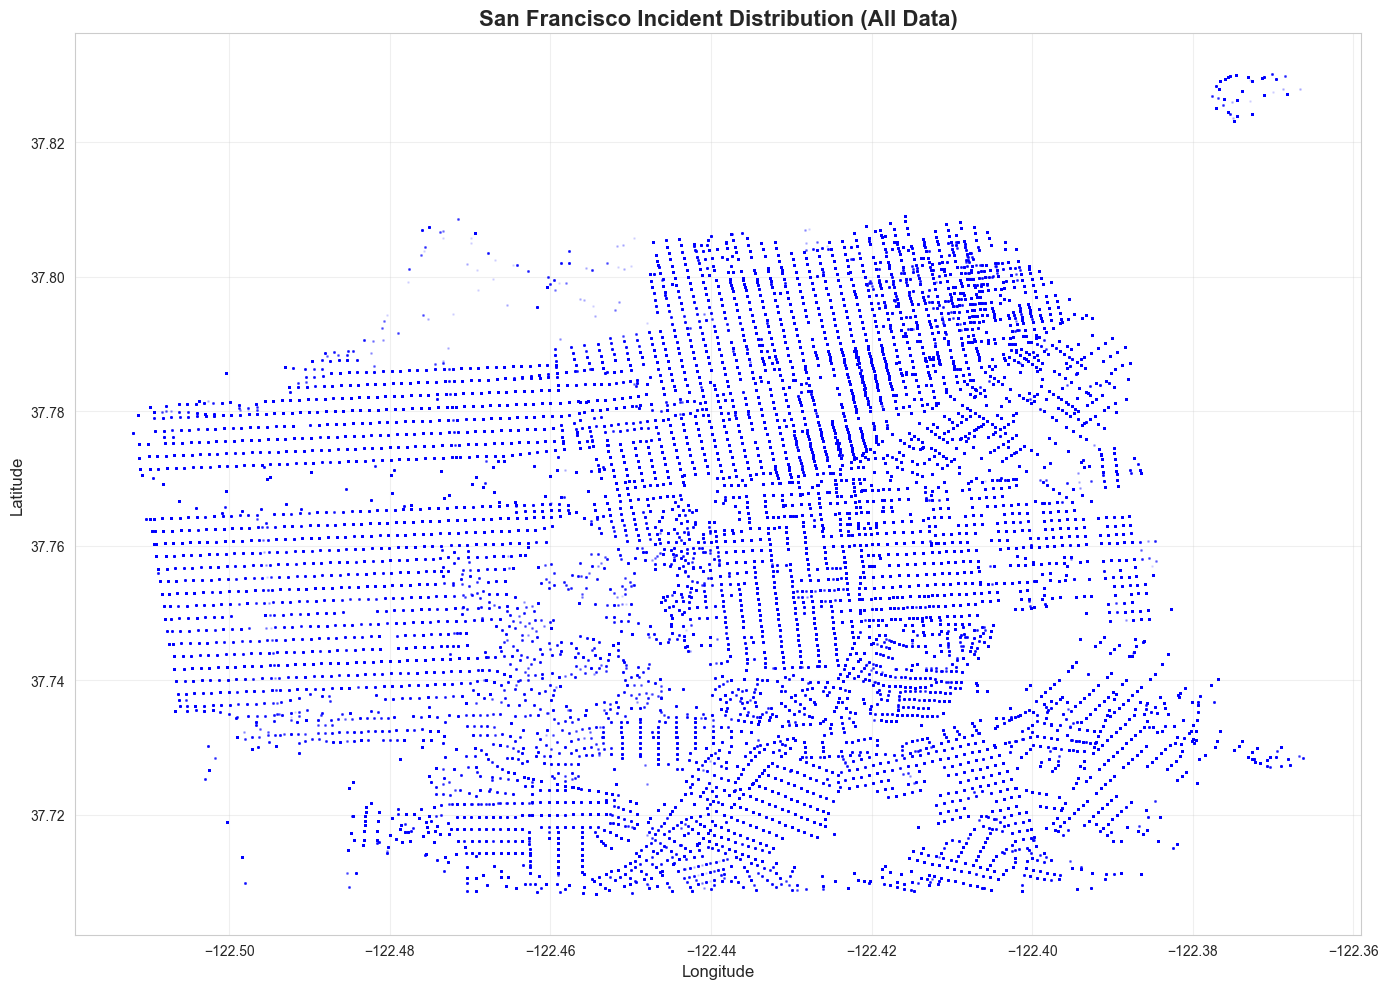

Total incidents: 819,722
Latitude range: [37.708256, 37.830055]
Longitude range: [-122.511940, -122.366287]


In [3]:
# Create a scatter plot of all incidents
plt.figure(figsize=(14, 10))
plt.scatter(df['Longitude'], df['Latitude'], alpha=0.1, s=1, c='blue')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('San Francisco Incident Distribution (All Data)', fontsize=16, weight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total incidents: {len(df):,}")
print(f"Latitude range: [{df['Latitude'].min():.6f}, {df['Latitude'].max():.6f}]")
print(f"Longitude range: [{df['Longitude'].min():.6f}, {df['Longitude'].max():.6f}]")


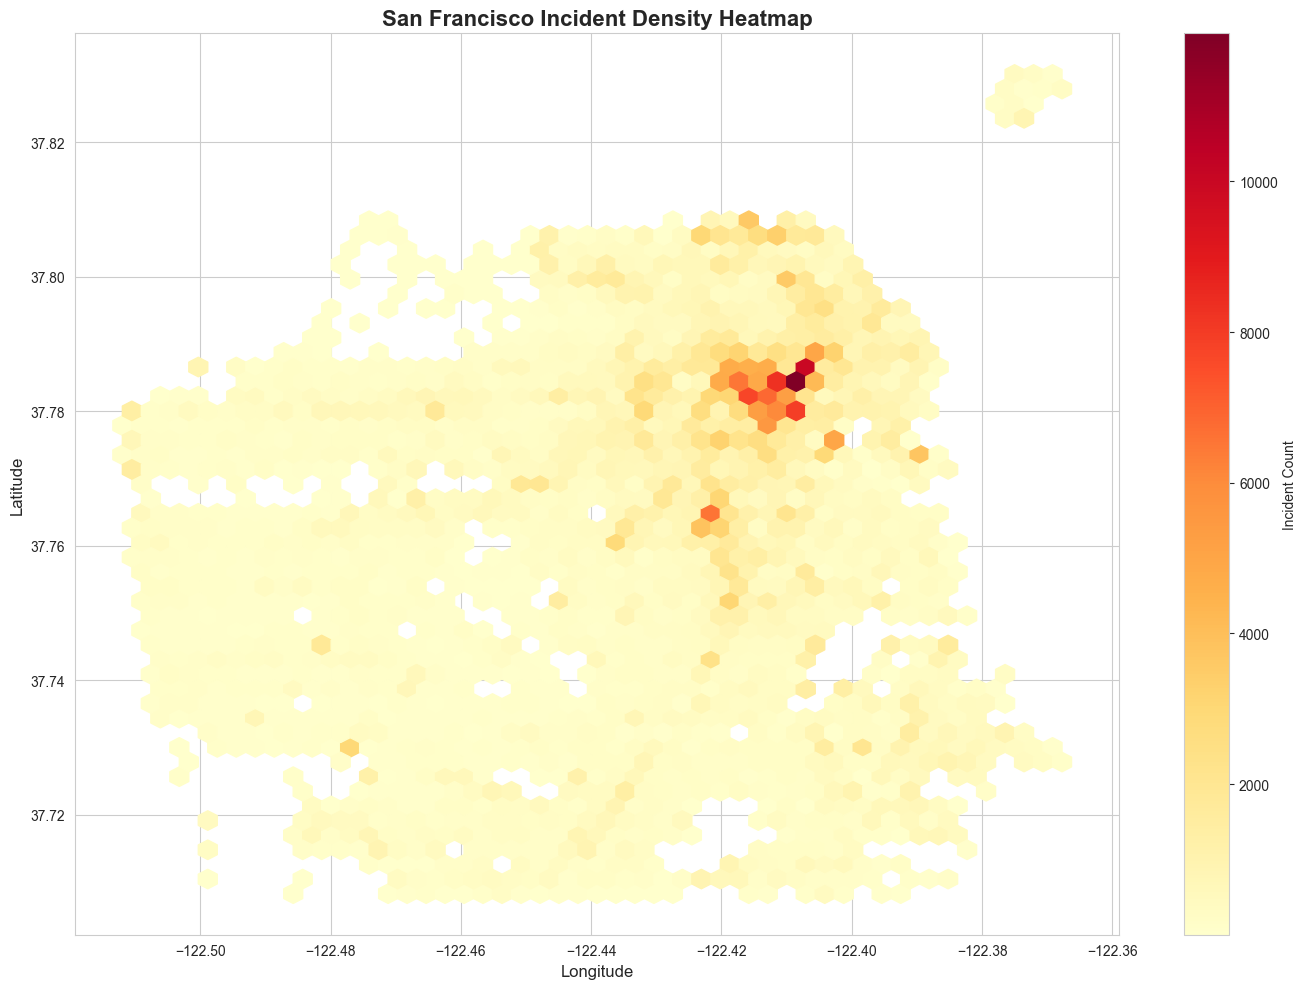

In [4]:
# Create hexbin density plot for better visualization
plt.figure(figsize=(14, 10))
plt.hexbin(df['Longitude'], df['Latitude'], gridsize=50, cmap='YlOrRd', mincnt=1)
plt.colorbar(label='Incident Count')
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('San Francisco Incident Density Heatmap', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()


## 4. Prepare Data for DBSCAN

DBSCAN requires coordinates in a format where distances are meaningful. We'll use the raw lat/lon coordinates, but for large datasets, we may need to sample.


In [5]:
# Extract coordinates for clustering
coords = df[['Latitude', 'Longitude']].values

print(f"Total incidents for clustering: {len(coords):,}")
print(f"Coordinates shape: {coords.shape}")

# For computational efficiency, we'll sample if dataset is too large
# DBSCAN can be computationally expensive on very large datasets
MAX_SAMPLES = 100000

if len(coords) > MAX_SAMPLES:
    print(f"\nDataset is large ({len(coords):,} points). Sampling {MAX_SAMPLES:,} points for analysis...")
    np.random.seed(42)
    sample_indices = np.random.choice(len(coords), size=MAX_SAMPLES, replace=False)
    coords_sample = coords[sample_indices]
    df_sample = df.iloc[sample_indices].copy()
    print(f"Sample created: {len(coords_sample):,} points")
else:
    coords_sample = coords
    df_sample = df.copy()
    print("Using full dataset for analysis")


Total incidents for clustering: 819,722
Coordinates shape: (819722, 2)

Dataset is large (819,722 points). Sampling 100,000 points for analysis...
Sample created: 100,000 points


## 5. Determine Optimal DBSCAN Parameters

DBSCAN requires two key parameters:
- **eps** (epsilon): Maximum distance between two samples for one to be considered as in the neighborhood of the other
- **min_samples**: Minimum number of samples in a neighborhood for a point to be considered a core point

We'll use the **k-distance graph** method to find optimal eps.


Computing k-nearest neighbors for 50,000 points...


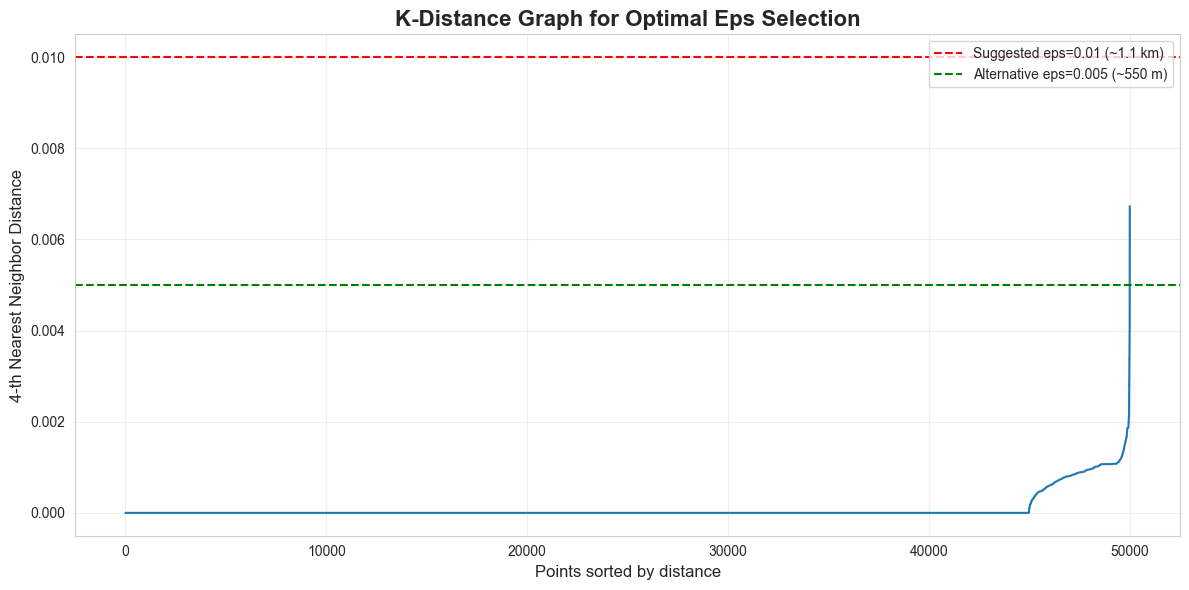


PARAMETER SELECTION GUIDANCE
For geographic coordinates (lat/lon):
  - eps = 0.005 ≈ 550 meters (tight clusters)
  - eps = 0.01 ≈ 1.1 km (medium clusters)
  - eps = 0.02 ≈ 2.2 km (broad clusters)

min_samples = 4 (minimum points to form a cluster)

Look for the 'elbow' in the graph above to determine optimal eps.


In [6]:
# Use k-nearest neighbors to determine optimal eps
min_samples = 4

# For very large datasets, use a subset for k-distance calculation
if len(coords_sample) > 50000:
    coords_kdist = coords_sample[np.random.choice(len(coords_sample), 50000, replace=False)]
else:
    coords_kdist = coords_sample

print(f"Computing k-nearest neighbors for {len(coords_kdist):,} points...")
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(coords_kdist)
distances, indices = neighbors_fit.kneighbors(coords_kdist)

# Sort distances
distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance', fontsize=12)
plt.title('K-Distance Graph for Optimal Eps Selection', fontsize=16, weight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=0.01, color='r', linestyle='--', label='Suggested eps=0.01 (~1.1 km)')
plt.axhline(y=0.005, color='g', linestyle='--', label='Alternative eps=0.005 (~550 m)')
plt.legend()
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PARAMETER SELECTION GUIDANCE")
print("="*60)
print("For geographic coordinates (lat/lon):")
print("  - eps = 0.005 ≈ 550 meters (tight clusters)")
print("  - eps = 0.01 ≈ 1.1 km (medium clusters)")
print("  - eps = 0.02 ≈ 2.2 km (broad clusters)")
print(f"\nmin_samples = {min_samples} (minimum points to form a cluster)")
print("\nLook for the 'elbow' in the graph above to determine optimal eps.")


## 6. Apply DBSCAN Clustering

Based on the k-distance graph, we'll apply DBSCAN with selected parameters.


In [7]:
# Set DBSCAN parameters
eps = 0.01  # approximately 1.1 km
min_samples = 4

print(f"Running DBSCAN with eps={eps} (~1.1 km) and min_samples={min_samples}...")
print(f"Clustering {len(coords_sample):,} incidents...")

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
clusters = dbscan.fit_predict(coords_sample)

# Add cluster labels to dataframe
df_sample['Cluster'] = clusters

# Analyze results
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
n_noise = list(clusters).count(-1)
n_clustered = len(clusters) - n_noise

print("\n" + "="*60)
print("DBSCAN CLUSTERING RESULTS")
print("="*60)
print(f"Number of clusters found: {n_clusters:,}")
print(f"Noise points (outliers): {n_noise:,} ({100*n_noise/len(clusters):.2f}%)")
print(f"Clustered points: {n_clustered:,} ({100*n_clustered/len(clusters):.2f}%)")
print(f"Average cluster size: {n_clustered/n_clusters if n_clusters > 0 else 0:.1f} incidents")

# Display cluster size distribution
if n_clusters > 0:
    cluster_sizes = df_sample[df_sample['Cluster'] != -1].groupby('Cluster').size()
    print(f"\nCluster size statistics:")
    print(f"  Min: {cluster_sizes.min():,} incidents")
    print(f"  Max: {cluster_sizes.max():,} incidents")
    print(f"  Median: {cluster_sizes.median():.0f} incidents")
    print(f"  Mean: {cluster_sizes.mean():.1f} incidents")


Running DBSCAN with eps=0.01 (~1.1 km) and min_samples=4...
Clustering 100,000 incidents...

DBSCAN CLUSTERING RESULTS
Number of clusters found: 2
Noise points (outliers): 0 (0.00%)
Clustered points: 100,000 (100.00%)
Average cluster size: 50000.0 incidents

Cluster size statistics:
  Min: 377 incidents
  Max: 99,623 incidents
  Median: 50000 incidents
  Mean: 50000.0 incidents


## 7. Visualize Clusters


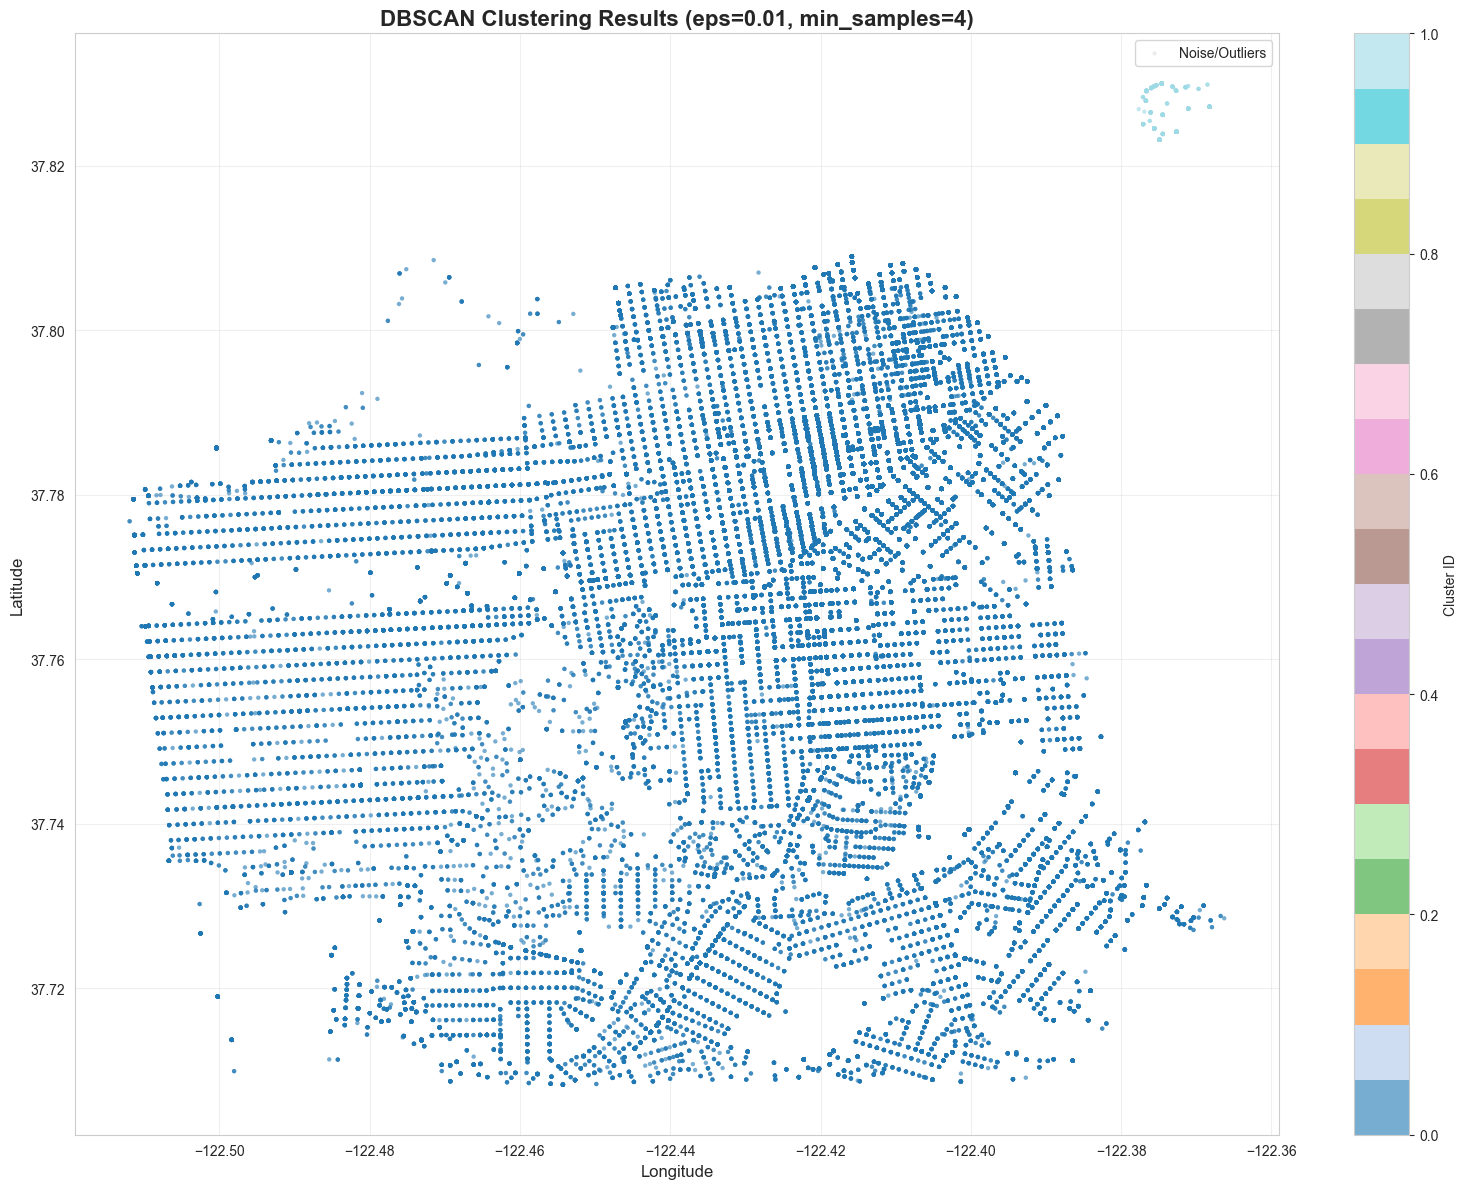

In [8]:
# Visualize clusters on a map
plt.figure(figsize=(16, 12))

# Plot noise points in gray
noise_mask = df_sample['Cluster'] == -1
plt.scatter(
    df_sample.loc[noise_mask, 'Longitude'],
    df_sample.loc[noise_mask, 'Latitude'],
    c='lightgray',
    alpha=0.3,
    s=5,
    label='Noise/Outliers'
)

# Plot clustered points with colors
clustered_mask = df_sample['Cluster'] != -1
if clustered_mask.sum() > 0:
    scatter = plt.scatter(
        df_sample.loc[clustered_mask, 'Longitude'],
        df_sample.loc[clustered_mask, 'Latitude'],
        c=df_sample.loc[clustered_mask, 'Cluster'],
        cmap='tab20',
        alpha=0.6,
        s=10,
        edgecolors='none'
    )
    plt.colorbar(scatter, label='Cluster ID')

plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title(f'DBSCAN Clustering Results (eps={eps}, min_samples={min_samples})', 
          fontsize=16, weight='bold')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save figure
output_dir = Path('../reports/figures')
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / '07_dbscan_clusters_overview.png', dpi=300, bbox_inches='tight')

plt.show()


## 8. Analyze Top Hotspot Clusters



TOP 20 INCIDENT HOTSPOTS (Largest Clusters)
         Center_Lat   Size  Center_Lon     Neighborhood
Cluster                                                
0         37.768539  99623 -122.424524          Mission
1         37.826264    377 -122.374000  Treasure Island


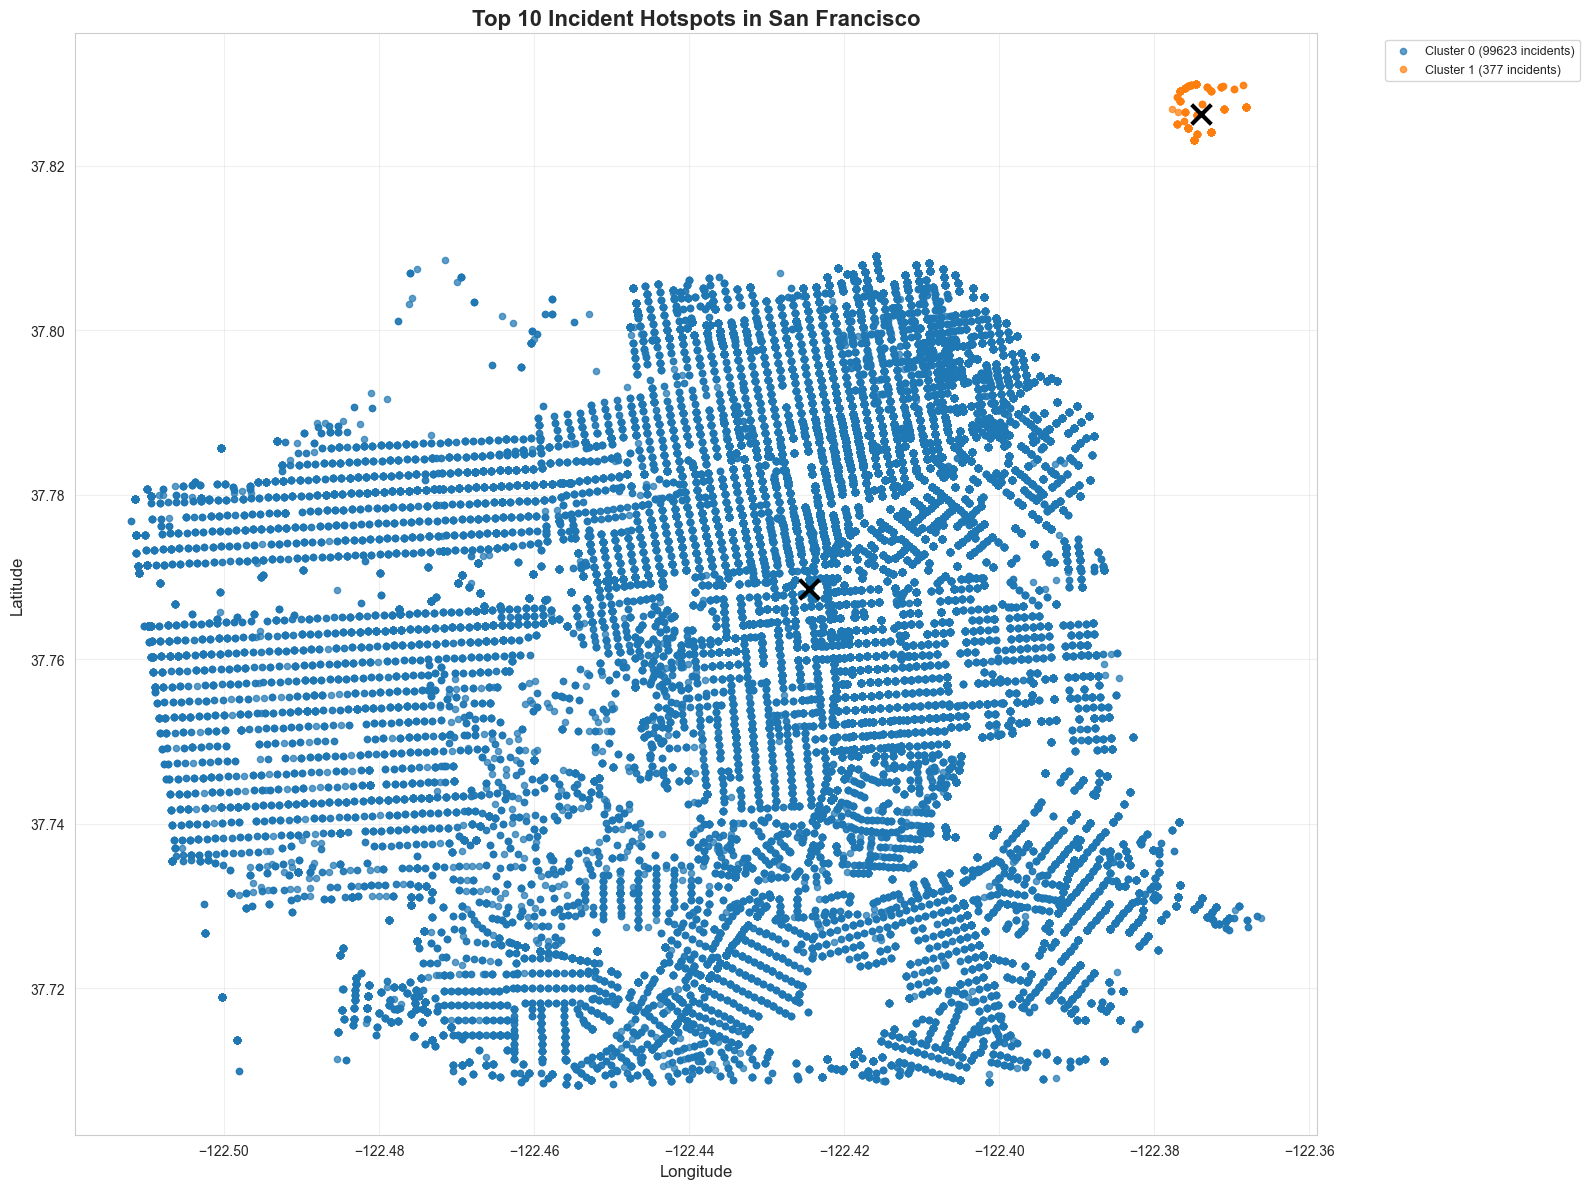

In [9]:
# Identify top clusters by size
if n_clusters > 0:
    cluster_info = df_sample[df_sample['Cluster'] != -1].groupby('Cluster').agg({
        'Latitude': ['mean', 'count'],
        'Longitude': 'mean',
        'Neighborhood': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
    }).round(6)
    
    cluster_info.columns = ['Center_Lat', 'Size', 'Center_Lon', 'Neighborhood']
    cluster_info = cluster_info.sort_values('Size', ascending=False)
    
    print("\n" + "="*80)
    print("TOP 20 INCIDENT HOTSPOTS (Largest Clusters)")
    print("="*80)
    print(cluster_info.head(20).to_string())
    
    # Visualize top 10 clusters
    top_10_clusters = cluster_info.head(10).index.tolist()
    
    plt.figure(figsize=(16, 12))
    
    # Plot all points in light gray as background
    plt.scatter(
        df_sample['Longitude'],
        df_sample['Latitude'],
        c='lightgray',
        alpha=0.2,
        s=3
    )
    
    # Highlight top 10 clusters
    for i, cluster_id in enumerate(top_10_clusters):
        cluster_data = df_sample[df_sample['Cluster'] == cluster_id]
        plt.scatter(
            cluster_data['Longitude'],
            cluster_data['Latitude'],
            label=f"Cluster {cluster_id} ({len(cluster_data)} incidents)",
            s=20,
            alpha=0.7
        )
        
        # Add cluster center marker
        center_lat = cluster_info.loc[cluster_id, 'Center_Lat']
        center_lon = cluster_info.loc[cluster_id, 'Center_Lon']
        plt.scatter(center_lon, center_lat, marker='x', s=200, c='black', linewidths=3)
    
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('Top 10 Incident Hotspots in San Francisco', fontsize=16, weight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(output_dir / '08_top_10_hotspots.png', dpi=300, bbox_inches='tight')
    
    plt.show()
else:
    print("No clusters found to analyze.")


## 9. Summary and Key Findings


In [12]:
print("="*80)
print("SPATIAL ANALYSIS SUMMARY - SAN FRANCISCO INCIDENTS")
print("="*80)
print(f"\n📊 Dataset Information:")
print(f"   • Total incidents analyzed: {len(df_sample):,}")
print(f"   • Date range: {df_sample.index.min().date()} to {df_sample.index.max().date()}")

print(f"\n🎯 DBSCAN Parameters:")
print(f"   • Epsilon (eps): {eps} (~1.1 km radius)")
print(f"   • Minimum samples: {min_samples}")

print(f"\n🗺️ Clustering Results:")
print(f"   • Number of clusters identified: {n_clusters:,}")
print(f"   • Incidents in clusters: {n_clustered:,} ({100*n_clustered/len(clusters):.1f}%)")
print(f"   • Noise/outlier points: {n_noise:,} ({100*n_noise/len(clusters):.1f}%)")

if n_clusters > 0:
    print(f"\n📈 Cluster Statistics:")
    print(f"   • Average cluster size: {cluster_sizes.mean():.1f} incidents")
    print(f"   • Median cluster size: {cluster_sizes.median():.0f} incidents")
    print(f"   • Largest cluster: {cluster_sizes.max():,} incidents")
    print(f"   • Smallest cluster: {cluster_sizes.min():,} incidents")
    
    print(f"\n🔥 Top 5 Hotspots:")
    for i, (cluster_id, row) in enumerate(cluster_info.head(5).iterrows(), 1):
        print(f"   {i}. Cluster {cluster_id}: {row['Size']:,} incidents - {row['Neighborhood']}")

print(f"\n💡 Key Insights:")
print("   • DBSCAN successfully identified spatial crime hotspots")
print("   • Hotspots represent areas requiring enhanced public safety resources")
print("   • Cluster analysis reveals geographic concentration of incident types")
print("   • Results can inform strategic deployment of law enforcement")

print("\n" + "="*80)


SPATIAL ANALYSIS SUMMARY - SAN FRANCISCO INCIDENTS

📊 Dataset Information:
   • Total incidents analyzed: 100,000
   • Date range: 2018-01-01 to 2025-10-31

🎯 DBSCAN Parameters:
   • Epsilon (eps): 0.01 (~1.1 km radius)
   • Minimum samples: 4

🗺️ Clustering Results:
   • Number of clusters identified: 2
   • Incidents in clusters: 100,000 (100.0%)
   • Noise/outlier points: 0 (0.0%)

📈 Cluster Statistics:
   • Average cluster size: 50000.0 incidents
   • Median cluster size: 50000 incidents
   • Largest cluster: 99,623 incidents
   • Smallest cluster: 377 incidents

🔥 Top 5 Hotspots:
   1. Cluster 0: 99,623 incidents - Mission
   2. Cluster 1: 377 incidents - Treasure Island

💡 Key Insights:
   • DBSCAN successfully identified spatial crime hotspots
   • Hotspots represent areas requiring enhanced public safety resources
   • Cluster analysis reveals geographic concentration of incident types
   • Results can inform strategic deployment of law enforcement

